In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

import h2o
import seaborn as sns
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset

from sklearn import metrics
import matplotlib
matplotlib.__version__

ModuleNotFoundError: No module named 'h2o'

In [ ]:
def responseClassify_binary(row, baseline, _next):
    # set threshold
    lower_change = 0.6
    upper_change = 1.2

    change = row[_next]
    row[_next] = row[baseline] - change

    if change <= lower_change:
        return "Nonresponder"

    elif (change <= upper_change) & (change > lower_change):
        if row[_next] > 5.1:
            return "Nonresponder"
        else:
            return "Responder"

    elif change > upper_change:
        if row[_next] > 3.2:
            return "Responder"
        else:
            return "Responder"

    else:
        return 2
    
def MSE(true, pred):
    return metrics.mean_squared_error(true, pred)
    
def Classification_Accuracy(true, pred):
    return metrics.accuracy_score(true, pred)

def R2(true, pred):
    return metrics.r2_score(true, pred)

def Adjusted_R2(true, pred, p):
    n = len(true)
    return 1-((1-R2(true,pred))*(n-1))/(n-p-1)

def F1_Score(true, pred):
    return metrics.f1_score(true, pred, average='macro')

def RPT(stability,performance,beta=1):
    return (beta**2+1)*stability*performance / (beta**2*stability+performance)

def calculate_RPT(row, metrics):
    stability = row[f'{metrics}_std']
    performance = row[f'{metrics}_mean']
    if metrics == 'mse':
        performance = 1 / performance
        stability = 1 / stability
    return RPT(stability,performance,beta=1)

In [2]:
df = pd.read_csv('/Users/gaskell/Dropbox/Mac/Desktop/leaderboard/SC_regression_Aug22_imputation_comparison_output.csv')
df

,dataset,challenge,imputation,model_id,mae_mean,mean_residual_deviance_mean,mse_mean,null_deviance_mean,r2_mean,residual_deviance_mean,rmse_mean,rmsle_mean,mae_std,mean_residual_deviance_std,mse_std,null_deviance_std,r2_std,residual_deviance_std,rmse_std,rmsle_std
0,val,regression_delta,None,StackedEnsemble_BestOfFamily_1_AutoML_1_202208...,0.911349,1.217443,1.217443,45.388905,0.155519,35.265965,1.092238,0.508872,0.156791,0.365049,0.365049,13.630799,0.159945,11.543893,0.156392,0.108204
1,val,regression_delta,None,GBM_grid_1_AutoML_1_20220822_101813_model_2,0.926346,1.277686,1.277686,NaN,0.096150,1.277686,1.123452,0.584127,0.109786,0.267232,0.267232,NaN,0.186232,0.267232,0.124670,0.166414
2,val,regression_delta,None,GBM_grid_2_AutoML_2_20220822_102256_model_2,0.926346,1.277686,1.277686,NaN,0.096150,1.277686,1.123452,0.584127,0.109786,0.267232,0.267232,NaN,0.186232,0.267232,0.124670,0.166414
3,val,regression_delta,None,DeepLearning_grid_5_AutoML_2_20220822_102256_m...,0.898730,1.260111,1.260111,NaN,0.134027,1.260111,1.109462,0.565261,0.124964,0.396963,0.396963,NaN,0.137145,0.396963,0.170897,0.163836
4,val,regression_delta,None,StackedEnsemble_AllModels_1_AutoML_1_20220822_...,0.907806,1.268758,1.268758,45.210827,0.106555,36.152420,1.118461,0.505399,0.097985,0.308699,0.308699,11.301543,0.184090,7.452820,0.133424,0.061374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,val,regression_delta,IterativeImputer,XGBoost_grid_1_AutoML_6_20220822_104220_model_3,0.996050,1.547240,1.547240,NaN,-0.062689,1.547240,1.230954,0.647333,0.149004,0.426056,0.426056,NaN,0.203517,0.426056,0.178861,0.214024
103,val,regression_delta,IterativeImputer,DeepLearning_1_AutoML_6_20220822_104220,0.992545,1.560481,1.560481,NaN,-0.048433,1.560481,1.234241,0.646032,0.143981,0.447019,0.447019,NaN,0.105874,0.447019,0.192694,0.225163
104,val,regression_delta,IterativeImputer,XGBoost_1_AutoML_6_20220822_104220,0.995203,1.560677,1.560677,NaN,-0.083665,1.560677,1.239035,0.647176,0.142363,0.380858,0.380858,NaN,0.223007,0.380858,0.159594,0.176915
105,val,regression_delta,IterativeImputer,XGBoost_grid_1_AutoML_6_20220822_104220_model_1,1.004832,1.573682,1.573682,NaN,-0.135813,1.573682,1.249046,0.713956,0.096424,0.283278,0.283278,NaN,0.354851,0.283278,0.116474,0.337433


In [3]:
def add_model_family(row):
    if "StackedEnsemble" in row['model_id']:
        return '_'.join(row['model_id'].split('_',3)[:2])
    else:
        return row['model_id'].split('_')[0]

In [4]:
# df_dev = df.drop(columns=['process_approach','imputation','patient_group','drug_group','train_test_rate','remove_low_DAS','random_state'])
df_dev = df
df_dev.loc[:,'model_family'] = df_dev.apply(lambda row:add_model_family(row),axis=1)
# df_dev.loc[:,'RPT'] = df_dev.apply(lambda row: calculate_RPT(row,'mse'), axis=1)
# df_dev = df_dev.sort_values(by='mse_mean',ascending=True).reset_index(drop=True)
df_dev

,dataset,challenge,imputation,model_id,mae_mean,mean_residual_deviance_mean,mse_mean,null_deviance_mean,r2_mean,residual_deviance_mean,...,rmsle_mean,mae_std,mean_residual_deviance_std,mse_std,null_deviance_std,r2_std,residual_deviance_std,rmse_std,rmsle_std,model_family
0,val,regression_delta,None,StackedEnsemble_BestOfFamily_1_AutoML_1_202208...,0.911349,1.217443,1.217443,45.388905,0.155519,35.265965,...,0.508872,0.156791,0.365049,0.365049,13.630799,0.159945,11.543893,0.156392,0.108204,StackedEnsemble_BestOfFamily
1,val,regression_delta,None,GBM_grid_1_AutoML_1_20220822_101813_model_2,0.926346,1.277686,1.277686,NaN,0.096150,1.277686,...,0.584127,0.109786,0.267232,0.267232,NaN,0.186232,0.267232,0.124670,0.166414,GBM
2,val,regression_delta,None,GBM_grid_2_AutoML_2_20220822_102256_model_2,0.926346,1.277686,1.277686,NaN,0.096150,1.277686,...,0.584127,0.109786,0.267232,0.267232,NaN,0.186232,0.267232,0.124670,0.166414,GBM
3,val,regression_delta,None,DeepLearning_grid_5_AutoML_2_20220822_102256_m...,0.898730,1.260111,1.260111,NaN,0.134027,1.260111,...,0.565261,0.124964,0.396963,0.396963,NaN,0.137145,0.396963,0.170897,0.163836,DeepLearning
4,val,regression_delta,None,StackedEnsemble_AllModels_1_AutoML_1_20220822_...,0.907806,1.268758,1.268758,45.210827,0.106555,36.152420,...,0.505399,0.097985,0.308699,0.308699,11.301543,0.184090,7.452820,0.133424,0.061374,StackedEnsemble_AllModels
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,val,regression_delta,IterativeImputer,XGBoost_grid_1_AutoML_6_20220822_104220_model_3,0.996050,1.547240,1.547240,NaN,-0.062689,1.547240,...,0.647333,0.149004,0.426056,0.426056,NaN,0.203517,0.426056,0.178861,0.214024,XGBoost
103,val,regression_delta,IterativeImputer,DeepLearning_1_AutoML_6_20220822_104220,0.992545,1.560481,1.560481,NaN,-0.048433,1.560481,...,0.646032,0.143981,0.447019,0.447019,NaN,0.105874,0.447019,0.192694,0.225163,DeepLearning
104,val,regression_delta,IterativeImputer,XGBoost_1_AutoML_6_20220822_104220,0.995203,1.560677,1.560677,NaN,-0.083665,1.560677,...,0.647176,0.142363,0.380858,0.380858,NaN,0.223007,0.380858,0.159594,0.176915,XGBoost
105,val,regression_delta,IterativeImputer,XGBoost_grid_1_AutoML_6_20220822_104220_model_1,1.004832,1.573682,1.573682,NaN,-0.135813,1.573682,...,0.713956,0.096424,0.283278,0.283278,NaN,0.354851,0.283278,0.116474,0.337433,XGBoost


In [5]:
df_dev.to_csv("/Users/gaskell/Dropbox/Mac/Desktop/leaderboard/imputation_comparison.csv",index=False)

In [15]:
df_dev.sort_values(by='mse_mean',ascending=True)[['model_id','mse_mean','mse_std']].head(20)

,model_id,mse_mean,mse_std
2,StackedEnsemble_AllModels_4_AutoML_10_20220803...,1.144793,0.342046
0,StackedEnsemble_AllModels_6_AutoML_10_20220803...,1.147471,0.357300
1,StackedEnsemble_BestOfFamily_5_AutoML_10_20220...,1.185015,0.131595
13,GLM_1_AutoML_10_20220803_231402,1.190525,0.304809
8,StackedEnsemble_AllModels_2_AutoML_10_20220803...,1.191027,0.280622
3,StackedEnsemble_BestOfFamily_7_AutoML_10_20220...,1.195037,0.356811
5,StackedEnsemble_BestOfFamily_4_AutoML_10_20220...,1.208599,0.214775
4,StackedEnsemble_AllModels_3_AutoML_10_20220803...,1.210660,0.142289
7,StackedEnsemble_Best1000_1_AutoML_10_20220803_...,1.228128,0.319942
6,XRT_1_AutoML_10_20220803_231402,1.240541,0.250231


In [23]:
def error_bar_plot(df, evaluation_metrics):
    if evaluation_metrics == 'r2' or evaluation_metrics == 'RPT':
        selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
        selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
        y = selected_models[f'{evaluation_metrics}_mean']
        x = y.index
        y_error = selected_models[f'{evaluation_metrics}_std']
    else:
        selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=True).groupby('model_family').first()
        selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=True)
        y = selected_models[f'{evaluation_metrics}_mean']
        x = y.index
        y_error = selected_models[f'{evaluation_metrics}_std']
   
    y_1 = [round(a,2) for a in y]
    y_perc = [round(a*100,1) for a in y]
#     print(min(y_error[:2]))
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,6)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.1)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'accuracy':
        ax1.set_ylim(50,100)
        bars = ax1.bar(x,y_perc,color=colors)
    elif evaluation_metrics == 'RPT':
        ax1.set_ylim(1,1.75)
        bars = ax1.bar(x,y_1,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel(evaluation_metrics.upper(), fontsize=20)
    
    if evaluation_metrics == 'RPT':
        pass
    
    else:
        ax1.bar_label(bars, label_type='center',color='white', fontsize=12)

        ax1.errorbar(x, y, yerr=y_error,
                  fmt='o', color='orange', ecolor='orange',
                  elinewidth = 3, capsize=10)
        extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig('mse.png', bbox_inches=extent)
        
        ax2.scatter(y,y_error)
        for i in range(len(x)):
            alignment = 'left' if y[i] < 1.22 else 'right'
            ax2.text(x=y[i], y=y_error[i], s=x[i], 
                     horizontalalignment=alignment, verticalalignment='bottom',
                     fontdict=dict(color='black', alpha=0.8, size=16))
        ax2.plot([min(y), max(y)], [min(y_error), max(y_error)], ls="--", c=".3")
        ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
        ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

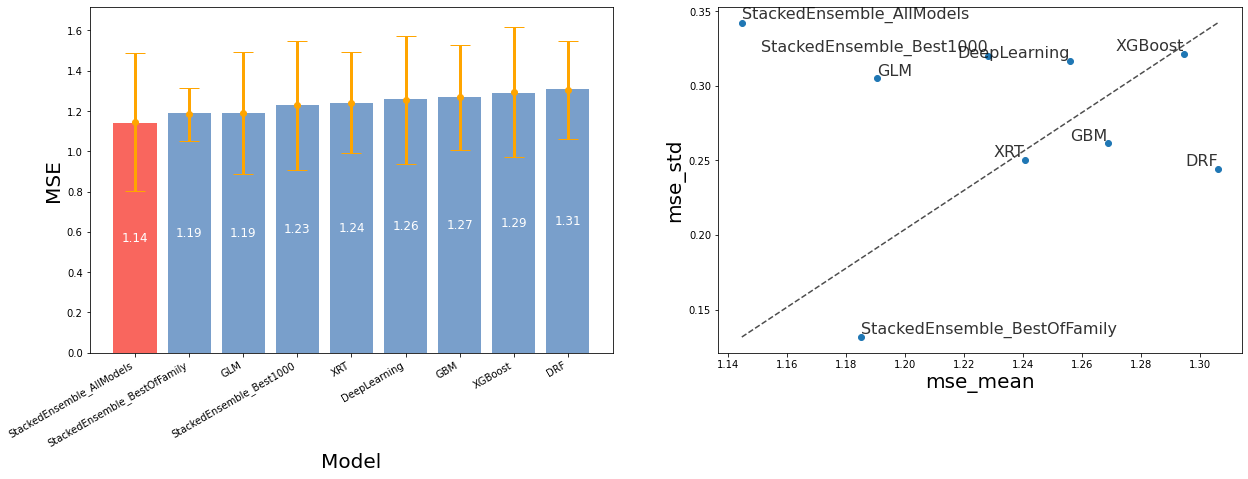

In [24]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df_dev, 'mse')

In [18]:
dataset = CoronnaCERTAINDataset(
    library_root = 'Dataset/',
    challenge = 'regression_delta', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = None, #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = ['bionaive TNF'], #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.8,
    remove_low_DAS = True,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
# train_h2o = h2o.upload_file(str(train_loc))
# test_h2o = h2o.upload_file(str(test_loc))
train_h2o = h2o.import_file(str(train_loc))
test_h2o = h2o.import_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = dataset.target

for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
if "classification" in dataset.challenge:
    train_h2o[y] = train_h2o[y].asfactor()
    test_h2o[y] = test_h2o[y].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 .

/gpfs/home/sc9295/Projects/ML_RA_EHR/DataModule/Data_Preparation.py:269: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.drop(df.std()[(df.std() == 0)].index, axis=1) # drop constant column


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3fe7uu8y
  JVM stdout: /tmp/tmp3fe7uu8y/h2o_sc9295_started_from_python.out
  JVM stderr: /tmp/tmp3fe7uu8y/h2o_sc9295_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_sc9295_8u58ad
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.923 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_4_AutoML_10_20220803_231402

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.05079677182289476
RMSE: 0.2253813919179992
MAE: 0.17565860619008047
RMSLE: NaN
R^2: 0.9668735089746627
Mean Residual Deviance: 0.05079677182289476
Null degrees of freedom: 291
Residual degrees of freedom: 282
Null deviance: 447.75818123749684
Residual deviance: 14.832657372285269
AIC: -19.477258785877012

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1.1911952056737434
RMSE: 1.0914188956004671
MAE: 0.8936456231097085
RMSLE: NaN
R^2: 0.22317667296348076
Mean Residual Deviance: 1.1911952056737434
Null degrees of freedom: 291
Residual degrees of freedom: 282
Null deviance: 455.1533426939474
Residual deviance: 347.8290000567331
AIC: 901.7475992485615

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.873764,0.142874,1.007515,1.098520,0.859105,0.823247,0.908740,0.797605,0.634188,0.738848,0.829013,1.040858
1,mean_residual_deviance,1.144793,0.360548,1.514041,1.669320,1.237277,0.874078,1.153358,1.134540,0.553676,0.723891,1.064272,1.523480
2,mse,1.144793,0.360548,1.514041,1.669320,1.237277,0.874078,1.153358,1.134540,0.553676,0.723891,1.064272,1.523480
3,null_deviance,45.515335,16.944532,58.272484,80.303085,48.642086,35.885780,47.055904,37.221725,27.649343,20.076227,53.926792,46.119915
4,r2,0.189021,0.225436,-0.032518,-0.060782,0.375761,0.403090,0.079426,0.114541,0.499297,-0.015898,0.485294,0.041995
5,residual_deviance,34.782900,17.328089,49.963350,71.780740,28.457365,20.977873,40.367527,31.767110,13.841894,18.821163,27.671062,44.180916
6,rmse,1.056967,0.175164,1.230464,1.292021,1.112329,0.934921,1.073945,1.065148,0.744094,0.850818,1.031635,1.234293
7,rmsle,0.487630,0.156592,0.466023,NaN,NaN,0.540027,0.622309,0.373206,0.302218,0.405372,0.405424,0.786463




ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.3984600921230403
RMSE: 1.18256504773439
MAE: 0.9709303990951922
RMSLE: NaN
R^2: -0.0043509415261402395
Mean Residual Deviance: 1.3984600921230403
Null degrees of freedom: 84
Residual degrees of freedom: 75
Null deviance: 123.86641497927927
Residual deviance: 118.86910783045843
AIC: 291.72614489419834

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
R2 -0.004350935682684964
Adjusted_R2 -1.7214670515272754

classification accuracy 0.7411764705882353
F1 score 0.5547619047619048


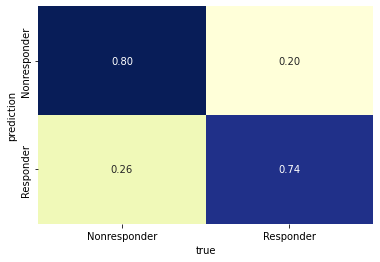

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_10_20220803_231402

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.10263126378913033
RMSE: 0.3203611458793503
MAE: 0.2562161595288577
RMSLE: NaN
R^2: 0.9330702814997132
Mean Residual Deviance: 0.10263126378913033
Null degrees of freedom: 291
Residual degrees of freedom: 286
Null deviance: 447.75818123749684
Residual deviance: 29.96832902642606
AIC: 177.8892016000506

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1.1796811292888623
RMSE: 1.086131267061612
MAE: 0.8904511608715322
RMSLE: NaN
R^2: 0.23068543649984552
Mean Residual Deviance: 1.1796811292888623
Null degrees of freedom: 291
Residual degrees of freedom: 287
Null deviance: 449.23497627244416
Residual deviance: 344.46688975234775
AIC: 888.9114017740285

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.895675,0.078698,0.806684,0.887434,0.953082,1.059987,0.877978,0.891469,0.862132,0.964719,0.855813,0.797456
1,mean_residual_deviance,1.185015,0.138714,1.085403,1.200738,1.142954,1.528684,1.124631,1.143790,1.114367,1.314785,1.080146,1.114648
2,mse,1.185015,0.138714,1.085403,1.200738,1.142954,1.528684,1.124631,1.143790,1.114367,1.314785,1.080146,1.114648
3,null_deviance,44.923496,12.775104,43.111600,71.539820,45.037346,39.191845,56.283802,56.067540,32.359776,35.393734,31.231610,39.017910
4,r2,0.187048,0.174351,0.158028,0.275420,0.410241,-0.015442,0.300647,0.427596,0.138003,-0.118046,0.098768,0.195263
5,residual_deviance,34.446690,7.410824,35.818300,51.631737,26.287935,36.688408,39.362090,32.026134,27.859167,35.499184,28.083786,31.210150
6,rmse,1.087041,0.061065,1.041827,1.095782,1.069090,1.236400,1.060486,1.069481,1.055636,1.146640,1.039301,1.055769
7,rmsle,0.544491,0.143189,NaN,NaN,0.506502,0.578601,0.451593,0.401557,0.458360,0.747532,0.772730,0.439051




ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.4678253740200677
RMSE: 1.2115384327457663
MAE: 0.9951119185785031
RMSLE: NaN
R^2: -0.05416794136397063
Mean Residual Deviance: 1.4678253740200677
Null degrees of freedom: 84
Residual degrees of freedom: 79
Null deviance: 123.86641497927927
Residual deviance: 124.76515679170575
AIC: 287.8410179323943

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


███████████████████████████████████████████| (done) 100%
R2 -0.05416793003497333
Adjusted_R2 -1.8564550362237986

classification accuracy 0.7529411764705882
F1 score 0.6051758460517584


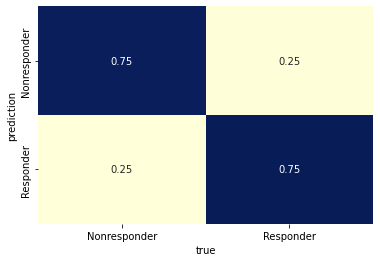

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_10_20220803_231402


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 0.5995 ),"nlambda = 30, lambda.max = 51.15, lambda.min = 0.5995, lambda.1se ...",76,76,15,AutoML_10_20220803_231402_training_py_9_sid_a500




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.0246098620721895
RMSE: 1.0122301428391616
MAE: 0.825973674831531
RMSLE: NaN
R^2: 0.33181325933967176
Mean Residual Deviance: 1.0246098620721895
Null degrees of freedom: 291
Residual degrees of freedom: 215
Null deviance: 447.75818123749684
Residual deviance: 299.18607972507937
AIC: 991.7591833794041

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1.260453048255043
RMSE: 1.1226990016273475
MAE: 0.9167528660726341
RMSLE: NaN
R^2: 0.17801102132123203
Mean Residual Deviance: 1.260453048255043
Null degrees of freedom: 291
Residual degrees of freedom: 216
Null deviance: 451.0829389675167
Residual deviance: 368.0522900904725
AIC: 1050.24969917706

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.895481,0.106056,0.940811,0.772398,1.023713,0.733819,0.839046,0.872079,1.031287,1.023097,0.845745,0.872811
1,mean_residual_deviance,1.190525,0.321297,1.311695,0.892138,1.515190,0.715196,1.062305,1.071953,1.801237,1.423464,1.063697,1.048375
2,mse,1.190525,0.321297,1.311695,0.892138,1.515190,0.715196,1.062305,1.071953,1.801237,1.423464,1.063697,1.048375
3,null_deviance,45.108295,13.843222,66.218610,26.832922,53.348330,37.314987,40.332924,33.150350,62.338030,57.849144,31.603975,42.093662
4,r2,0.166961,0.160452,0.405739,-0.112508,0.176243,0.340725,0.079277,0.056659,0.146643,0.281259,0.020822,0.274749
5,residual_deviance,34.745610,9.292582,39.350857,26.764132,43.940514,20.740686,30.806850,31.086634,52.235870,41.280468,30.847212,30.402882
6,rmse,1.082293,0.145933,1.145293,0.944530,1.230931,0.845693,1.030682,1.035351,1.342102,1.193090,1.031357,1.023902
7,rmsle,0.569497,0.172377,0.606474,0.498607,0.482280,0.319593,0.870893,0.753535,NaN,NaN,0.524378,0.500220



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-08-03 23:14:04,0.000 sec,1,.51E2,77,1.490735,1.514706,0.143533,0.0,NaN,,,,
1,,2022-08-03 23:14:04,0.000 sec,2,.37E2,77,1.476584,1.504753,0.141870,0.0,NaN,,,,
2,,2022-08-03 23:14:04,0.001 sec,3,.27E2,77,1.458514,1.492038,0.139739,0.0,NaN,,,,
3,,2022-08-03 23:14:04,0.001 sec,4,.2E2,77,1.435920,1.476191,0.137059,0.0,NaN,,,,
4,,2022-08-03 23:14:04,0.001 sec,5,.14E2,77,1.408440,1.457007,0.133789,0.0,NaN,,,,
5,,2022-08-03 23:14:04,0.002 sec,6,.1E2,77,1.376093,1.434622,0.129942,0.0,NaN,,,,
6,,2022-08-03 23:14:04,0.002 sec,7,.76E1,77,1.339335,1.409614,0.125617,0.0,NaN,,,,
7,,2022-08-03 23:14:04,0.003 sec,8,.55E1,77,1.299130,1.382990,0.121006,0.0,NaN,,,,
8,,2022-08-03 23:14:04,0.003 sec,9,.4E1,77,1.256766,1.356128,0.116372,0.0,NaN,,,,
9,,2022-08-03 23:14:04,0.004 sec,10,.29E1,77,1.213681,1.330590,0.112017,0.0,NaN,,,,



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,swollen_jts_28,0.186368,1.000000,0.069275
1,DAS28_CRP_0M,0.172190,0.923923,0.064005
2,usresultsCCP3,0.122698,0.658366,0.045608
3,tender_jts_28,0.115271,0.618511,0.042847
4,pt_global_assess,0.100422,0.538836,0.037328
5,age,0.068154,0.365696,0.025334
6,hxmi,0.067347,0.361365,0.025033
7,drinker.2,0.066652,0.357636,0.024775
8,ndmardused,0.066647,0.357610,0.024773
9,weight,0.064156,0.344244,0.023847



See the whole table with table.as_data_frame()


ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 1.426272487446699
RMSE: 1.1942665060390412
MAE: 0.9776177593868969
RMSLE: NaN
R^2: -0.024325344504638746
Mean Residual Deviance: 1.426272487446699
Null degrees of freedom: 84
Residual degrees of freedom: 8
Null deviance: 123.86641497927927
Residual deviance: 121.23316143296941
AIC: 427.40002370160437

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
R2 -0.02432533646978352
Adjusted_R2 -1.77559123430522

classification accuracy 0.7294117647058823
F1 score 0.4936544936544936


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


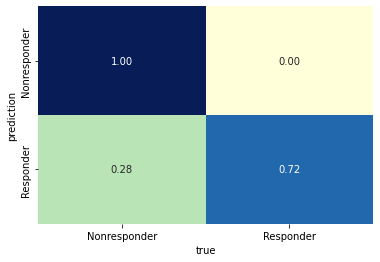

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_Best1000_1_AutoML_10_20220803_231402

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.05788739926465026
RMSE: 0.24059800345108906
MAE: 0.18950823959079313
RMSLE: NaN
R^2: 0.9622494433522986
Mean Residual Deviance: 0.05788739926465026
Null degrees of freedom: 291
Residual degrees of freedom: 278
Null deviance: 447.75818123749684
Residual deviance: 16.903120585277875
AIC: 26.677483559918812

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1.226928954622809
RMSE: 1.1076682511577232
MAE: 0.9054580831751268
RMSLE: NaN
R^2: 0.199873347350782
Mean Residual Deviance: 1.226928954622809
Null degrees of freedom: 291
Residual degrees of freedom: 281
Null deviance: 452.4406796525612
Residual deviance: 358.2632547498602
AIC: 912.3782680005042

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.905515,0.137874,0.985152,0.751150,0.746273,0.845619,1.023235,1.026519,1.022677,0.677668,1.033581,0.943272
1,mean_residual_deviance,1.228128,0.337249,1.445453,0.837545,0.818136,1.084982,1.477998,1.477097,1.360228,0.741639,1.728132,1.310070
2,mse,1.228128,0.337249,1.445453,0.837545,0.818136,1.084982,1.477998,1.477097,1.360228,0.741639,1.728132,1.310070
3,null_deviance,45.244070,19.912807,64.305320,48.735348,15.569129,26.241972,54.917927,49.457300,39.743900,28.171972,84.009810,41.288000
4,r2,0.091699,0.237980,0.296211,0.251787,-0.261296,-0.012501,0.009003,0.123973,0.011183,0.337512,0.420971,-0.259852
5,residual_deviance,35.826324,11.525480,44.809055,36.014420,19.635270,26.039576,53.207935,41.358727,34.005700,18.540985,46.659557,37.992030
6,rmse,1.098131,0.157187,1.202270,0.915175,0.904509,1.041625,1.215729,1.215359,1.166288,0.861185,1.314584,1.144583
7,rmsle,0.560313,0.232669,NaN,0.478811,0.382759,0.467688,NaN,0.464184,0.715345,0.341828,0.570497,1.061394




ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.4074839791284652
RMSE: 1.1863742997589188
MAE: 0.9740721675471643
RMSLE: NaN
R^2: -0.01083174813704968
Mean Residual Deviance: 1.4074839791284652
Null degrees of freedom: 84
Residual degrees of freedom: 71
Null deviance: 123.86641497927927
Residual deviance: 119.63613822591955
AIC: 300.272865014315

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


███████████████████████████████████████████| (done) 100%
R2 -0.010831741780662263
Adjusted_R2 -1.7390279454701818

classification accuracy 0.7411764705882353
F1 score 0.5547619047619048


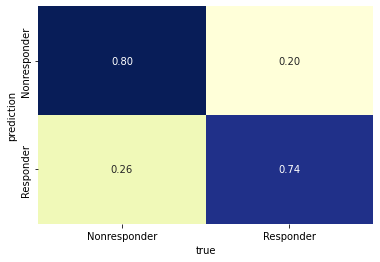

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_10_20220803_231402


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,72259.0,13.0,20.0,18.0,165.0,210.0,187.23334




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1.3843500535753517
RMSE: 1.1765840614148024
MAE: 0.9509029612713529
RMSLE: NaN
Mean Residual Deviance: 1.3843500535753517

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 1.21700750562548
RMSE: 1.1031806314586383
MAE: 0.912988663743466
RMSLE: NaN
Mean Residual Deviance: 1.21700750562548

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.920254,0.094988,1.051578,0.844950,0.932280,0.726444,0.947491,0.942014,1.002443,1.002694,0.845068,0.907573
1,mean_residual_deviance,1.240541,0.263766,1.549027,0.937991,1.269910,0.770301,1.252816,1.317624,1.662997,1.357902,1.131930,1.154908
2,mse,1.240541,0.263766,1.549027,0.937991,1.269910,0.770301,1.252816,1.317624,1.662997,1.357902,1.131930,1.154908
3,r2,0.116823,0.205477,0.298216,-0.169687,0.309593,0.289929,-0.085843,-0.159536,0.212136,0.314362,-0.041989,0.201051
4,residual_deviance,1.240541,0.263766,1.549027,0.937991,1.269910,0.770301,1.252816,1.317624,1.662997,1.357902,1.131930,1.154908
5,rmse,1.107829,0.121359,1.244599,0.968499,1.126903,0.877668,1.119293,1.147878,1.289572,1.165291,1.063922,1.074666
6,rmsle,0.572934,0.177437,0.628378,0.488425,0.468012,0.319470,0.868279,0.775779,NaN,NaN,0.531928,0.503202



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-03 23:14:33,7.960 sec,0.0,NaN,NaN,NaN
1,,2022-08-03 23:14:33,8.061 sec,5.0,1.488918,1.165825,2.216877
2,,2022-08-03 23:14:33,8.172 sec,10.0,1.376547,1.077223,1.894880
3,,2022-08-03 23:14:33,8.281 sec,15.0,1.283084,1.005663,1.646305
4,,2022-08-03 23:14:33,8.386 sec,20.0,1.236134,0.985412,1.528026
5,,2022-08-03 23:14:33,8.494 sec,25.0,1.196300,0.958908,1.431134
6,,2022-08-03 23:14:33,8.616 sec,30.0,1.176584,0.950903,1.384350



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,swollen_jts_28,1252.872314,1.000000,0.132410
1,DAS28_CRP_0M,1034.459106,0.825670,0.109327
2,tender_jts_28,479.413666,0.382652,0.050667
3,pt_global_assess,419.267944,0.334645,0.044311
4,usresultsCRP,407.831543,0.325517,0.043102
5,usresultsIgA,394.292023,0.314710,0.041671
6,usresultsIgG,352.644684,0.281469,0.037269
7,age,351.062683,0.280206,0.037102
8,md_global_assess,348.598206,0.278239,0.036842
9,usresultsIgM,347.920074,0.277698,0.036770



See the whole table with table.as_data_frame()


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 1.6039933403440487
RMSE: 1.2664885867405393
MAE: 1.0344319577076855
RMSLE: NaN
Mean Residual Deviance: 1.6039933403440487

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
R2 -0.151961513583045
Adjusted_R2 -2.1214441013217993

classification accuracy 0.7058823529411765
F1 score 0.4496244496244496


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


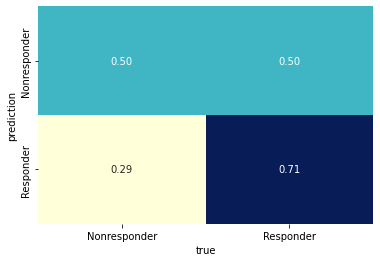

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_2_AutoML_10_20220803_231402_model_1


Status of Neuron Layers: predicting delta, regression, gaussian distribution, Quadratic loss, 6,851 weights/biases, 96.4 KB, 329,960 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,84,Input,5.0,,,,,,,,,
1,,2,50,RectifierDropout,50.0,0.0,0.0,0.099969,0.2947,0.0,-0.00783,0.167296,0.289861,0.167194
2,,3,50,RectifierDropout,50.0,0.0,0.0,0.001523,0.000949,0.0,-0.076923,0.162755,0.569778,0.130324
3,,4,1,Linear,,0.0,0.0,0.000417,0.000203,0.0,0.010191,0.210289,-0.041227,0.0




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.12108709213923015
RMSE: 0.3479757062486261
MAE: 0.24532120978619723
RMSLE: NaN
Mean Residual Deviance: 0.12108709213923015

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 1.2568278548604104
RMSE: 1.1210833398371463
MAE: 0.9036759144353878
RMSLE: NaN
Mean Residual Deviance: 1.2568278548604104

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.902761,0.117648,1.046424,0.797034,0.954073,0.716525,0.919090,0.876301,1.083746,0.993052,0.827238,0.814125
1,mean_residual_deviance,1.255916,0.333662,1.551151,1.003404,1.337302,0.802307,1.198920,1.152615,1.875973,1.601030,1.082172,0.954284
2,mse,1.255916,0.333662,1.551151,1.003404,1.337302,0.802307,1.198920,1.152615,1.875973,1.601030,1.082172,0.954284
3,r2,0.117241,0.189352,0.297254,-0.251258,0.272954,0.260426,-0.039130,-0.014325,0.111236,0.191601,0.003816,0.339840
4,residual_deviance,1.255916,0.333662,1.551151,1.003404,1.337302,0.802307,1.198920,1.152615,1.875973,1.601030,1.082172,0.954284
5,rmse,1.111997,0.146739,1.245452,1.001700,1.156418,0.895716,1.094952,1.073599,1.369662,1.265318,1.040275,0.976874
6,rmsle,0.569344,0.165609,0.601986,0.477592,0.468662,0.346947,0.841868,0.776833,NaN,NaN,0.540398,0.500468



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2
0,,2022-08-03 23:59:48,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,NaN
1,,2022-08-03 23:59:48,5 min 9.896 sec,24132 obs/sec,10.0,1,2920.0,1.176589,1.384362,0.941397,0.097206
2,,2022-08-03 23:59:53,5 min 14.897 sec,29108 obs/sec,510.0,51,148920.0,0.555171,0.308215,0.396285,0.799002
3,,2022-08-03 23:59:58,5 min 19.910 sec,32595 obs/sec,1130.0,113,329960.0,0.347976,0.121087,0.245321,0.921035



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,usresultsCRP,1.000000,1.000000,0.021668
1,race_grp.1,0.957302,0.957302,0.020743
2,hxmi,0.930304,0.930304,0.020158
3,drinksperwk,0.908681,0.908681,0.019689
4,ccpstatus_b,0.875111,0.875111,0.018962
5,hxunstab_ang,0.841282,0.841282,0.018229
6,ara_func_class.2,0.773801,0.773801,0.016766
7,drinker.1,0.770585,0.770585,0.016697
8,grp.3,0.759278,0.759278,0.016452
9,grp.2,0.744331,0.744331,0.016128



See the whole table with table.as_data_frame()


ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 1.39362302554259
RMSE: 1.1805181174139556
MAE: 0.9486428509440101
RMSLE: NaN
Mean Residual Deviance: 1.39362302554259

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
R2 -0.0008770297803950555
Adjusted_R2 -1.712053887146877

classification accuracy 0.7411764705882353
F1 score

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


 0.5955882352941175


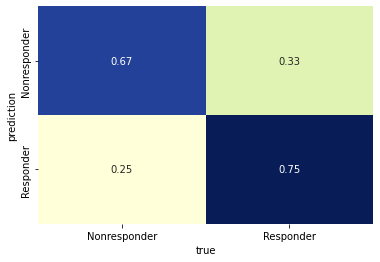

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_lr_annealing_selection_AutoML_10_20220803_231402_select_model


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,27.0,27.0,9567.0,5.0,5.0,5.0,16.0,31.0,23.555555




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.3860358160533646
RMSE: 0.6213178060005722
MAE: 0.5059750148873419
RMSLE: NaN
Mean Residual Deviance: 0.3860358160533646

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1.2369468118299503
RMSE: 1.112181105679264
MAE: 0.9242917784597665
RMSLE: NaN
Mean Residual Deviance: 1.2369468118299503

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.935835,0.112821,1.071175,0.747879,1.046358,0.775271,0.990671,0.917437,0.946317,1.063667,0.883625,0.915956
1,mean_residual_deviance,1.268699,0.275450,1.552135,0.823280,1.594461,0.881119,1.375558,1.228855,1.480725,1.493597,1.130041,1.127220
2,mse,1.268699,0.275450,1.552135,0.823280,1.594461,0.881119,1.375558,1.228855,1.480725,1.493597,1.130041,1.127220
3,r2,0.104174,0.175277,0.296808,-0.026641,0.133146,0.187776,-0.192226,-0.081418,0.298489,0.245847,-0.040250,0.220205
4,residual_deviance,1.268699,0.275450,1.552135,0.823280,1.594461,0.881119,1.375558,1.228855,1.480725,1.493597,1.130041,1.127220
5,rmse,1.119969,0.126351,1.245847,0.907348,1.262720,0.938679,1.172842,1.108537,1.216851,1.222128,1.063034,1.061706
6,rmsle,0.585516,0.180662,0.604009,0.457693,0.510201,0.355957,0.917534,0.777716,NaN,NaN,0.540341,0.520675



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-04 00:10:45,1.681 sec,0.0,1.238313,0.975157,1.533418
1,,2022-08-04 00:10:45,1.695 sec,5.0,1.045603,0.847199,1.093286
2,,2022-08-04 00:10:45,1.719 sec,10.0,0.909531,0.739167,0.827247
3,,2022-08-04 00:10:45,1.742 sec,15.0,0.784433,0.641042,0.615336
4,,2022-08-04 00:10:45,1.765 sec,20.0,0.723580,0.590667,0.523568
5,,2022-08-04 00:10:45,1.789 sec,25.0,0.647873,0.528569,0.419739
6,,2022-08-04 00:10:45,1.799 sec,27.0,0.621318,0.505975,0.386036



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,DAS28_CRP_0M,234.281570,1.000000,0.120507
1,swollen_jts_28,204.313797,0.872087,0.105092
2,md_global_assess,127.303864,0.543380,0.065481
3,usresultsIgG,114.220543,0.487535,0.058751
4,usresultsIgA,107.682091,0.459627,0.055388
5,pt_global_assess,93.718796,0.400026,0.048206
6,tender_jts_28,84.429222,0.360375,0.043428
7,BMI,66.666473,0.284557,0.034291
8,usresultsIgM,66.347946,0.283197,0.034127
9,grp,56.171356,0.239760,0.028893



See the whole table with table.as_data_frame()


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1.4096915791065447
RMSE: 1.1873043329772468
MAE: 0.9832976992972609
RMSLE: NaN
Mean Residual Deviance: 1.4096915791065447

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
R2 -0.012417199131603773
Adjusted_R2 -1.7433240234533782

classification accuracy

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


 0.7529411764705882
F1 score 0.5634629493763756


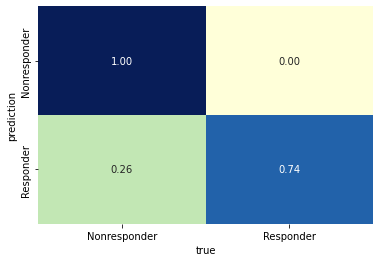

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_10_20220803_231402_model_13


Model Summary: 


,,number_of_trees
0,,42.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.5495044667542528
RMSE: 0.7412856849786409
MAE: 0.5825297696362823
RMSLE: NaN
Mean Residual Deviance: 0.5495044667542528

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 1.2950613021233623
RMSE: 1.1380076019620267
MAE: 0.9375673763785665
RMSLE: NaN
Mean Residual Deviance: 1.2950613021233623

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.937484,0.131680,1.113428,0.785901,1.001371,0.698239,0.901398,0.939154,0.968044,1.041483,0.847900,1.077921
1,mean_residual_deviance,1.294520,0.338662,1.821309,0.925663,1.396163,0.715259,1.144050,1.250848,1.520175,1.612814,1.060875,1.498050
2,mse,1.294520,0.338662,1.821309,0.925663,1.396163,0.715259,1.144050,1.250848,1.520175,1.612814,1.060875,1.498050
3,r2,0.096236,0.170208,0.174859,-0.154314,0.240954,0.340667,0.008427,-0.100772,0.279799,0.185651,0.023420,-0.036330
4,residual_deviance,1.294520,0.338662,1.821309,0.925663,1.396163,0.715259,1.144050,1.250848,1.520175,1.612814,1.060875,1.498050
5,rmse,1.128387,0.153709,1.349559,0.962114,1.181593,0.845730,1.069603,1.118413,1.232954,1.269966,1.029988,1.223949
6,rmsle,0.579432,0.180468,0.634464,0.489590,0.462075,0.312644,0.876890,0.780198,NaN,NaN,0.540540,0.539057



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-03 23:14:52,14.862 sec,0.0,1.627229,1.252516,2.647873
1,,2022-08-03 23:14:52,14.873 sec,5.0,1.248064,0.955454,1.557663
2,,2022-08-03 23:14:52,14.882 sec,10.0,1.113245,0.856985,1.239314
3,,2022-08-03 23:14:52,14.892 sec,15.0,1.022291,0.798360,1.045080
4,,2022-08-03 23:14:52,14.902 sec,20.0,0.948433,0.745840,0.899525
5,,2022-08-03 23:14:52,14.912 sec,25.0,0.885687,0.703137,0.784441
6,,2022-08-03 23:14:52,14.922 sec,30.0,0.833598,0.657466,0.694885
7,,2022-08-03 23:14:52,14.932 sec,35.0,0.791624,0.625524,0.626668
8,,2022-08-03 23:14:52,14.943 sec,40.0,0.757261,0.595030,0.573445
9,,2022-08-03 23:14:52,14.950 sec,42.0,0.741286,0.582530,0.549504



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,DAS28_CRP_0M,57.024239,1.000000,0.138841
1,usresultsIgA,27.905714,0.489366,0.067944
2,seatedbp1,24.904293,0.436732,0.060636
3,swollen_jts_28,23.296373,0.408535,0.056721
4,usresultsIgG,22.189655,0.389127,0.054027
5,weight,22.057465,0.386809,0.053705
6,usresultsRF,21.946966,0.384871,0.053436
7,seatedbp2,21.254570,0.372729,0.051750
8,usresultsIgM,17.508368,0.307034,0.042629
9,tender_jts_28,17.202307,0.301667,0.041884



See the whole table with table.as_data_frame()


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 1.4430753973698134
RMSE: 1.2012807321229344
MAE: 0.9982213669840028
RMSLE: NaN
Mean Residual Deviance: 1.4430753973698134

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
R2 -0.036392909943355756
Adjusted_R2 -1.8082904656529637

classification accuracy 0.6588235294117647
F1 score 

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


0.42794151775353917


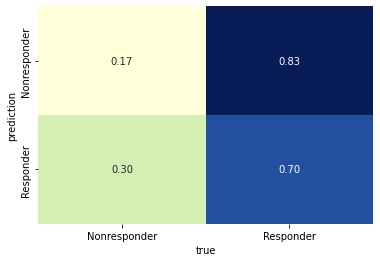

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_10_20220803_231402


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,34.0,34.0,80951.0,14.0,20.0,17.32353,166.0,206.0,184.64706




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1.319604842425048
RMSE: 1.1487405461743954
MAE: 0.9369444653567399
RMSLE: NaN
Mean Residual Deviance: 1.319604842425048

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 1.3020424104818307
RMSE: 1.1410707298330944
MAE: 0.9293194074045136
RMSLE: NaN
Mean Residual Deviance: 1.3020424104818307

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.935426,0.091722,1.045656,0.871124,1.022777,0.735373,1.005630,0.971815,0.949195,0.971139,0.884687,0.896865
1,mean_residual_deviance,1.305933,0.257406,1.594722,0.977790,1.517554,0.829245,1.466116,1.413643,1.522500,1.379948,1.254130,1.103677
2,mse,1.305933,0.257406,1.594722,0.977790,1.517554,0.829245,1.466116,1.413643,1.522500,1.379948,1.254130,1.103677
3,r2,0.061794,0.248394,0.277514,-0.219317,0.174957,0.235594,-0.270715,-0.244035,0.278698,0.303231,-0.154479,0.236492
4,residual_deviance,1.305933,0.257406,1.594722,0.977790,1.517554,0.829245,1.466116,1.413643,1.522500,1.379948,1.254130,1.103677
5,rmse,1.137302,0.117738,1.262823,0.988833,1.231891,0.910629,1.210833,1.188967,1.233896,1.174712,1.119880,1.050560
6,rmsle,0.585657,0.183366,0.621084,0.494078,0.494415,0.331828,0.901099,0.798080,NaN,NaN,0.534944,0.509725



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-03 23:14:14,7.394 sec,0.0,NaN,NaN,NaN
1,,2022-08-03 23:14:14,7.486 sec,5.0,1.384709,1.064569,1.917419
2,,2022-08-03 23:14:14,7.574 sec,10.0,1.254476,1.005402,1.573709
3,,2022-08-03 23:14:14,7.665 sec,15.0,1.216358,0.969852,1.479527
4,,2022-08-03 23:14:14,7.750 sec,20.0,1.208984,0.968044,1.461641
5,,2022-08-03 23:14:14,7.841 sec,25.0,1.161356,0.935694,1.348747
6,,2022-08-03 23:14:15,7.946 sec,30.0,1.157750,0.943947,1.340384
7,,2022-08-03 23:14:15,8.017 sec,34.0,1.148741,0.936944,1.319605



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,swollen_jts_28,1239.536987,1.000000,0.121306
1,DAS28_CRP_0M,1098.188354,0.885967,0.107473
2,tender_jts_28,674.542297,0.544189,0.066014
3,pt_global_assess,536.687073,0.432974,0.052522
4,md_global_assess,501.798431,0.404827,0.049108
5,usresultsIgG,419.547333,0.338471,0.041059
6,usresultsIgA,381.465668,0.307749,0.037332
7,usresultsCRP,374.476074,0.302110,0.036648
8,grp,349.347839,0.281837,0.034189
9,BMI,332.916046,0.268581,0.032581



See the whole table with table.as_data_frame()


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 1.4580730013523235
RMSE: 1.2075069363578512
MAE: 0.9741520247203023
RMSLE: NaN
Mean Residual Deviance: 1.4580730013523235

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
R2 -0.04716393697325039
Adjusted_R2 -1.8374764743791299

classification accuracy 0.7411764705882353
F1 score 0.5296780684104627


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


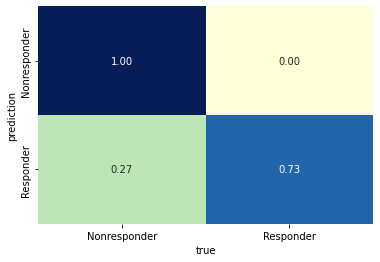

In [19]:
# regression
evaluation_metrics = 'mse'
model_path_dir = '/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/model_saved/'
model_id_list = list(df_dev.loc[df_dev.groupby('model_family')[f'{evaluation_metrics}_mean'].idxmin()].reset_index(drop=True).sort_values(by=f'{evaluation_metrics}_mean')['model_id'].values)
# model_id = model_id_list[0]
for i, model_id in enumerate(model_id_list):
    model_path = os.path.join(model_path_dir,model_id)
    uploaded_model = h2o.upload_model(model_path)
    m = h2o.get_model(model_id)
    print(m)
    print(m.model_performance(test_h2o))
    regression_pred = m.predict(test_h2o).as_data_frame()['predict']
    regression_true = test_h2o.as_data_frame()[dataset.target]
    m.model_performance(test_h2o)

    X = test.drop(columns=dataset.target)
    true = test[dataset.target]
    pred = m.predict(test_h2o).as_data_frame()
    
    print("R2", R2(true,pred))
    print("Adjusted_R2", Adjusted_R2(true,pred,len(test.columns)))
    print()

    baseline = test['DAS28_CRP_0M']

    baseline, true, pred = np.array(baseline), np.array(true), np.squeeze(np.array(pred))
    results_df = pd.DataFrame(list(zip(baseline, true, pred)),
                      columns=['baseline', 'true', 'pred'])

    classification_pred = results_df.apply(
        lambda row: responseClassify_binary(row, 'baseline', 'pred'), axis=1)

    classification_true = results_df.apply(
        lambda row: responseClassify_binary(row, 'baseline', 'true'), axis=1)

    print("classification accuracy", Classification_Accuracy(classification_true,classification_pred))
    print("F1 score", F1_Score(classification_true,classification_pred))

    contingency_matrix = pd.crosstab(classification_true, classification_pred, rownames=['true'], colnames=[
                                                 'prediction'], normalize='columns')
    plt.figure(i)
    sns.heatmap(contingency_matrix.T, annot=True,
                fmt='.2f', cmap="YlGnBu", cbar=False)
    plt.show()


In [20]:
model_path = '/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/model_saved/GLM_1_AutoML_10_20220803_231402'
uploaded_model = h2o.upload_model(model_path)
m = h2o.get_model('GLM_1_AutoML_10_20220803_231402')
m

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_1_AutoML_10_20220803_231402


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,Ridge ( lambda = 0.5995 ),"nlambda = 30, lambda.max = 51.15, lambda.min = 0.5995, lambda.1se ...",76,76,15,AutoML_10_20220803_231402_training_py_9_sid_a500




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.0246098620721895
RMSE: 1.0122301428391616
MAE: 0.825973674831531
RMSLE: NaN
R^2: 0.33181325933967176
Mean Residual Deviance: 1.0246098620721895
Null degrees of freedom: 291
Residual degrees of freedom: 215
Null deviance: 447.75818123749684
Residual deviance: 299.18607972507937
AIC: 991.7591833794041

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1.260453048255043
RMSE: 1.1226990016273475
MAE: 0.9167528660726341
RMSLE: NaN
R^2: 0.17801102132123203
Mean Residual Deviance: 1.260453048255043
Null degrees of freedom: 291
Residual degrees of freedom: 216
Null deviance: 451.0829389675167
Residual deviance: 368.0522900904725
AIC: 1050.24969917706

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.895481,0.106056,0.940811,0.772398,1.023713,0.733819,0.839046,0.872079,1.031287,1.023097,0.845745,0.872811
1,mean_residual_deviance,1.190525,0.321297,1.311695,0.892138,1.515190,0.715196,1.062305,1.071953,1.801237,1.423464,1.063697,1.048375
2,mse,1.190525,0.321297,1.311695,0.892138,1.515190,0.715196,1.062305,1.071953,1.801237,1.423464,1.063697,1.048375
3,null_deviance,45.108295,13.843222,66.218610,26.832922,53.348330,37.314987,40.332924,33.150350,62.338030,57.849144,31.603975,42.093662
4,r2,0.166961,0.160452,0.405739,-0.112508,0.176243,0.340725,0.079277,0.056659,0.146643,0.281259,0.020822,0.274749
5,residual_deviance,34.745610,9.292582,39.350857,26.764132,43.940514,20.740686,30.806850,31.086634,52.235870,41.280468,30.847212,30.402882
6,rmse,1.082293,0.145933,1.145293,0.944530,1.230931,0.845693,1.030682,1.035351,1.342102,1.193090,1.031357,1.023902
7,rmsle,0.569497,0.172377,0.606474,0.498607,0.482280,0.319593,0.870893,0.753535,NaN,NaN,0.524378,0.500220



Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_xval,deviance_se,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2
0,,2022-08-03 23:14:04,0.000 sec,1,.51E2,77,1.490735,1.514706,0.143533,0.0,NaN,,,,
1,,2022-08-03 23:14:04,0.000 sec,2,.37E2,77,1.476584,1.504753,0.141870,0.0,NaN,,,,
2,,2022-08-03 23:14:04,0.001 sec,3,.27E2,77,1.458514,1.492038,0.139739,0.0,NaN,,,,
3,,2022-08-03 23:14:04,0.001 sec,4,.2E2,77,1.435920,1.476191,0.137059,0.0,NaN,,,,
4,,2022-08-03 23:14:04,0.001 sec,5,.14E2,77,1.408440,1.457007,0.133789,0.0,NaN,,,,
5,,2022-08-03 23:14:04,0.002 sec,6,.1E2,77,1.376093,1.434622,0.129942,0.0,NaN,,,,
6,,2022-08-03 23:14:04,0.002 sec,7,.76E1,77,1.339335,1.409614,0.125617,0.0,NaN,,,,
7,,2022-08-03 23:14:04,0.003 sec,8,.55E1,77,1.299130,1.382990,0.121006,0.0,NaN,,,,
8,,2022-08-03 23:14:04,0.003 sec,9,.4E1,77,1.256766,1.356128,0.116372,0.0,NaN,,,,
9,,2022-08-03 23:14:04,0.004 sec,10,.29E1,77,1.213681,1.330590,0.112017,0.0,NaN,,,,



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,swollen_jts_28,0.186368,1.000000,0.069275
1,DAS28_CRP_0M,0.172190,0.923923,0.064005
2,usresultsCCP3,0.122698,0.658366,0.045608
3,tender_jts_28,0.115271,0.618511,0.042847
4,pt_global_assess,0.100422,0.538836,0.037328
5,age,0.068154,0.365696,0.025334
6,hxmi,0.067347,0.361365,0.025033
7,drinker.2,0.066652,0.357636,0.024775
8,ndmardused,0.066647,0.357610,0.024773
9,weight,0.064156,0.344244,0.023847



See the whole table with table.as_data_frame()


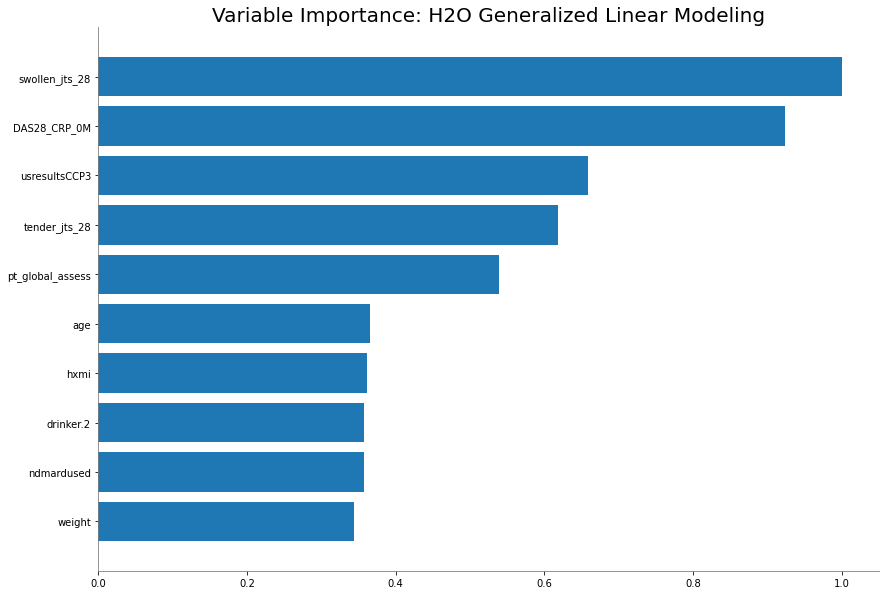

<Figure size 432x288 with 0 Axes>

In [21]:
m.varimp_plot()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


dataset,challenge,model_id,mae_mean,mean_residual_deviance_mean,mse_mean,null_deviance_mean,r2_mean,residual_deviance_mean,rmse_mean,rmsle_mean,mae_std,mean_residual_deviance_std,mse_std,null_deviance_std,r2_std,residual_deviance_std,rmse_std,rmsle_std
val,regression_delta,StackedEnsemble_AllModels_4_AutoML_10_20220803_231402,0.873764,1.14479,1.14479,45.5153,0.189021,34.7829,1.05697,0.48763,0.135542,0.342046,0.342046,16.075,0.213868,16.4389,0.166175,0.146478
val,regression_delta,StackedEnsemble_BestOfFamily_5_AutoML_10_20220803_231402,0.895675,1.18501,1.18501,44.9235,0.187048,34.4467,1.08704,0.544491,0.0746593,0.131595,0.131595,12.1195,0.165404,7.03053,0.0579309,0.133941
val,regression_delta,GLM_1_AutoML_10_20220803_231402,0.895481,1.19053,1.19053,45.1083,0.166961,34.7456,1.08229,0.569497,0.100614,0.304809,0.304809,13.1328,0.152218,8.81572,0.138444,0.161244
val,regression_delta,StackedEnsemble_Best1000_1_AutoML_10_20220803_231402,0.905515,1.22813,1.22813,45.2441,0.0916992,35.8263,1.09813,0.560313,0.130799,0.319942,0.319942,18.8909,0.225768,10.934,0.149121,0.217642
val,regression_delta,XRT_1_AutoML_10_20220803_231402,0.920254,1.24054,1.24054,nan,0.116823,1.24054,1.10783,0.572934,0.0901134,0.250231,0.250231,nan,0.194933,0.250231,0.115131,0.165977
val,regression_delta,DeepLearning_grid_2_AutoML_10_20220803_231402_model_1,0.902761,1.25592,1.25592,nan,0.117241,1.25592,1.112,0.569344,0.11161,0.31654,0.31654,nan,0.179635,0.31654,0.139209,0.154913
val,regression_delta,GBM_lr_annealing_selection_AutoML_10_20220803_231402_select_model,0.935835,1.2687,1.2687,nan,0.104174,1.2687,1.11997,0.585516,0.107032,0.261315,0.261315,nan,0.166282,0.261315,0.119867,0.168994
val,regression_delta,XGBoost_grid_1_AutoML_10_20220803_231402_model_13,0.937484,1.29452,1.29452,nan,0.0962362,1.29452,1.12839,0.579432,0.124922,0.321283,0.321283,nan,0.161473,0.321283,0.145821,0.168812
val,regression_delta,DRF_1_AutoML_10_20220803_231402,0.935426,1.30593,1.30593,nan,0.0617938,1.30593,1.1373,0.585657,0.087015,0.244197,0.244197,nan,0.235647,0.244197,0.111696,0.171523


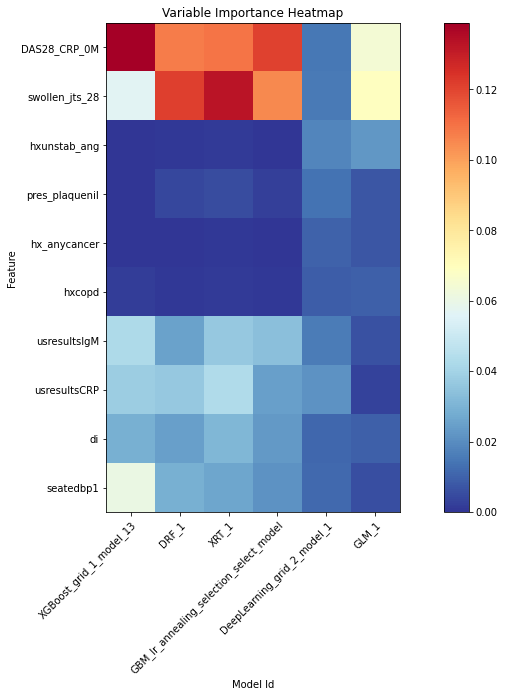

In [22]:
df = pd.read_csv('/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/SC_regression_Aug3_final_output.csv')
df.loc[:,'model_family'] = df.apply(lambda row:add_model_family(row),axis=1)

selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=True).groupby('model_family').first()
selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=True)
model_list = selected_models['model_id'].values
        
# model_list = df['model_id'].values
df = h2o.H2OFrame(selected_models)

for model in model_list:
    model_path = os.path.join('/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/model_saved/', model)
    h2o.upload_model(model_path)
    
print(df)
    
h2o.varimp_heatmap(df, test_h2o,num_of_features=10)

# Binary Classification

In [9]:
df = pd.read_csv('/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/SC_binary_classification_Aug4_final_output.csv')
df

,dataset,challenge,model_id,accuracy_mean,auc_mean,err_mean,err_count_mean,f0point5_mean,f1_mean,f2_mean,...,mean_per_class_error_std,mse_std,null_deviance_std,pr_auc_std,precision_std,r2_std,recall_std,residual_deviance_std,rmse_std,specificity_std
0,val,binary_classification,StackedEnsemble_AllModels_1_AutoML_1_20220804_...,0.815990,0.666888,0.184010,5.4,0.842711,0.887580,0.939577,...,0.095561,0.046609,8.283022,0.118542,0.071284,0.120851,0.036840,9.713376,0.052893,0.218321
1,val,binary_classification,StackedEnsemble_BestOfFamily_6_AutoML_1_202208...,0.828071,0.651656,0.171929,5.2,0.849919,0.897547,0.952459,...,0.139783,0.041778,8.327864,0.114058,0.075947,0.112366,0.017647,9.322161,0.054707,0.286492
2,val,binary_classification,GBM_2_AutoML_1_20220804_103358,0.808391,0.640671,0.191609,5.6,0.845798,0.881896,0.924961,...,0.088293,0.022200,NaN,0.046179,0.074371,0.221489,0.071722,NaN,0.026451,0.238266
3,val,binary_classification,GBM_grid_1_AutoML_1_20220804_103358_model_32,0.791379,0.605760,0.208621,6.1,0.825258,0.876629,0.936424,...,0.078460,0.025356,NaN,0.063448,0.062336,0.171710,0.029828,NaN,0.030080,0.180194
4,val,binary_classification,StackedEnsemble_BestOfFamily_4_AutoML_1_202208...,0.818094,0.672763,0.181906,5.5,0.842862,0.892491,0.951005,...,0.116881,0.050358,8.941074,0.087876,0.096601,0.104859,0.010714,9.497374,0.061690,0.235155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,val,binary_classification,DeepLearning_grid_1_AutoML_1_20220804_103358_m...,0.770920,0.552447,0.229080,6.7,0.807260,0.866422,0.935900,...,0.044211,0.050770,NaN,0.075382,0.056814,0.428615,0.031579,NaN,0.047802,0.120000
174,val,binary_classification,GBM_grid_1_AutoML_1_20220804_103358_model_35,0.764023,0.500000,0.235977,6.9,0.801054,0.864636,0.940518,...,0.000000,0.034665,NaN,0.066492,0.066492,0.067519,0.000000,NaN,0.041848,0.000000
175,val,binary_classification,DeepLearning_grid_2_AutoML_1_20220804_103358_m...,0.791264,0.553545,0.208736,6.1,0.820474,0.877726,0.944340,...,0.054866,0.071899,NaN,0.069520,0.052064,0.359703,0.014286,NaN,0.069551,0.114833
176,val,binary_classification,DeepLearning_grid_1_AutoML_1_20220804_103358_m...,0.791034,0.548674,0.208966,6.1,0.825152,0.876282,0.935801,...,0.087176,0.052489,NaN,0.071296,0.061029,0.356946,0.037242,NaN,0.052737,0.207881


In [10]:
df_dev = df
df_dev.loc[:,'model_family'] = df_dev.apply(lambda row:add_model_family(row),axis=1)
df_dev

,dataset,challenge,model_id,accuracy_mean,auc_mean,err_mean,err_count_mean,f0point5_mean,f1_mean,f2_mean,...,mse_std,null_deviance_std,pr_auc_std,precision_std,r2_std,recall_std,residual_deviance_std,rmse_std,specificity_std,model_family
0,val,binary_classification,StackedEnsemble_AllModels_1_AutoML_1_20220804_...,0.815990,0.666888,0.184010,5.4,0.842711,0.887580,0.939577,...,0.046609,8.283022,0.118542,0.071284,0.120851,0.036840,9.713376,0.052893,0.218321,StackedEnsemble_AllModels
1,val,binary_classification,StackedEnsemble_BestOfFamily_6_AutoML_1_202208...,0.828071,0.651656,0.171929,5.2,0.849919,0.897547,0.952459,...,0.041778,8.327864,0.114058,0.075947,0.112366,0.017647,9.322161,0.054707,0.286492,StackedEnsemble_BestOfFamily
2,val,binary_classification,GBM_2_AutoML_1_20220804_103358,0.808391,0.640671,0.191609,5.6,0.845798,0.881896,0.924961,...,0.022200,NaN,0.046179,0.074371,0.221489,0.071722,NaN,0.026451,0.238266,GBM
3,val,binary_classification,GBM_grid_1_AutoML_1_20220804_103358_model_32,0.791379,0.605760,0.208621,6.1,0.825258,0.876629,0.936424,...,0.025356,NaN,0.063448,0.062336,0.171710,0.029828,NaN,0.030080,0.180194,GBM
4,val,binary_classification,StackedEnsemble_BestOfFamily_4_AutoML_1_202208...,0.818094,0.672763,0.181906,5.5,0.842862,0.892491,0.951005,...,0.050358,8.941074,0.087876,0.096601,0.104859,0.010714,9.497374,0.061690,0.235155,StackedEnsemble_BestOfFamily
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,val,binary_classification,DeepLearning_grid_1_AutoML_1_20220804_103358_m...,0.770920,0.552447,0.229080,6.7,0.807260,0.866422,0.935900,...,0.050770,NaN,0.075382,0.056814,0.428615,0.031579,NaN,0.047802,0.120000,DeepLearning
174,val,binary_classification,GBM_grid_1_AutoML_1_20220804_103358_model_35,0.764023,0.500000,0.235977,6.9,0.801054,0.864636,0.940518,...,0.034665,NaN,0.066492,0.066492,0.067519,0.000000,NaN,0.041848,0.000000,GBM
175,val,binary_classification,DeepLearning_grid_2_AutoML_1_20220804_103358_m...,0.791264,0.553545,0.208736,6.1,0.820474,0.877726,0.944340,...,0.071899,NaN,0.069520,0.052064,0.359703,0.014286,NaN,0.069551,0.114833,DeepLearning
176,val,binary_classification,DeepLearning_grid_1_AutoML_1_20220804_103358_m...,0.791034,0.548674,0.208966,6.1,0.825152,0.876282,0.935801,...,0.052489,NaN,0.071296,0.061029,0.356946,0.037242,NaN,0.052737,0.207881,DeepLearning


In [11]:
def addlabels(ax,x,y):
    for i in range(len(x)):
        ax.text(i, (y[i]+50)//2, y[i], ha = 'center', color='white',fontsize=12)

In [12]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
#     x = list(df['model_id'])
#     y = df[f'{evaluation_metrics}_mean']
    y_1 = [round(a,2) for a in y]
#     y_error = df[f'{evaluation_metrics}_std']
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'accuracy':
        ax1.set_ylim(50,100)
        bars = ax1.bar(x,y_perc,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
    addlabels(ax1,x,y_perc)
#     ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Accuracy(%)', fontsize=20)
    
    ax1.errorbar(x, y_perc, yerr=y_error_perc,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
    

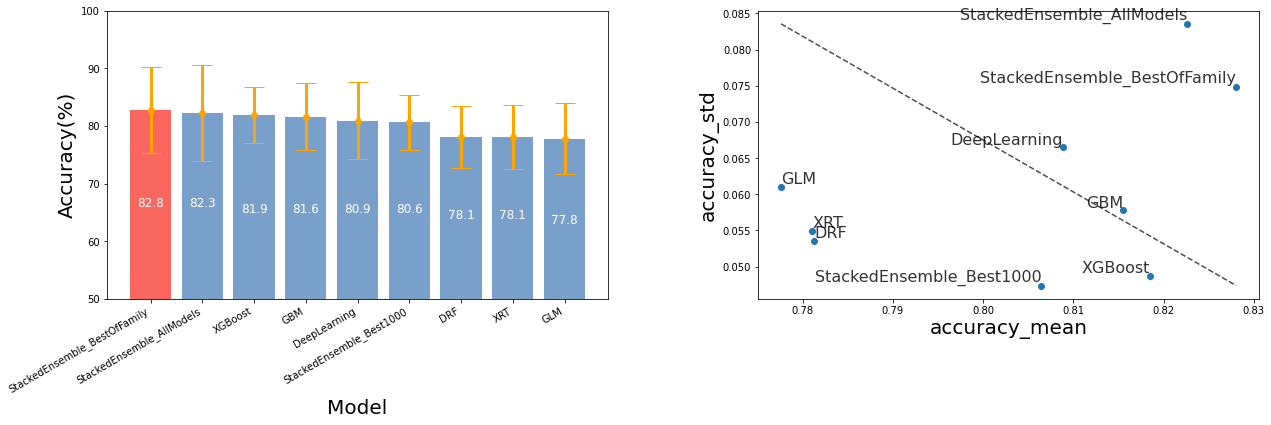

In [13]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df_dev, 'accuracy')

In [15]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
    y_1 = [round(a,2) for a in y]
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 1 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'auc':
        ax1.set_ylim(0,1)
        bars = ax1.bar(x,y_1,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
#     addlabels(ax1,x,y_1)
    ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Area under ROC', fontsize=20)
    
    ax1.errorbar(x, y, yerr=y_error,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
    

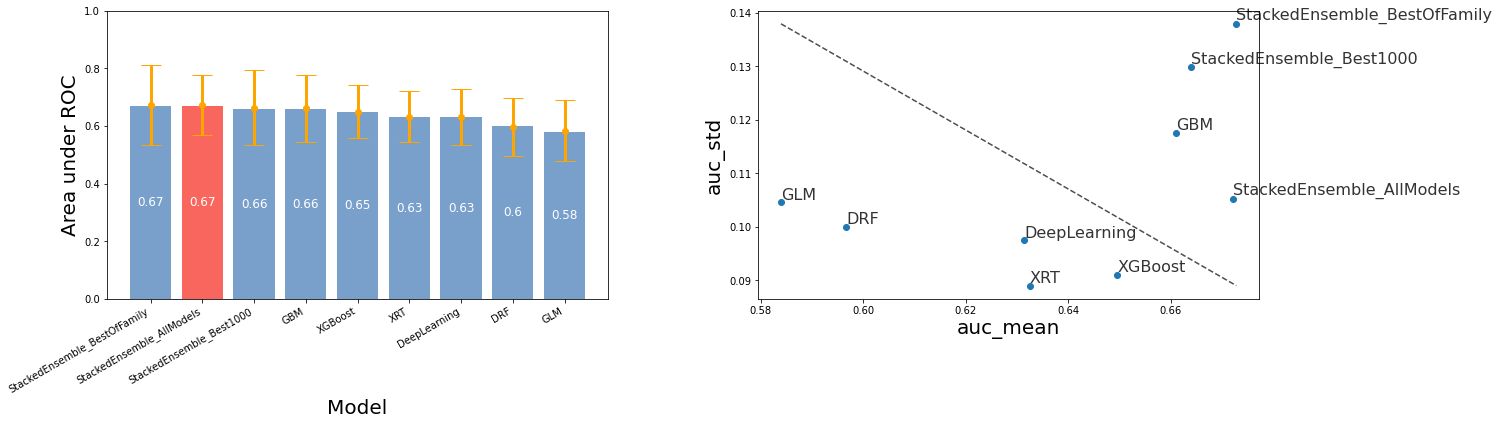

In [16]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df_dev, 'auc')

In [17]:
dataset = CoronnaCERTAINDataset(
    library_root = 'Dataset/',
    challenge = 'binary_classification', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = None, #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = ['bionaive TNF'], #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.8,
    remove_low_DAS = True,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
# train_h2o = h2o.upload_file(str(train_loc))
# test_h2o = h2o.upload_file(str(test_loc))
train_h2o = h2o.import_file(str(train_loc))
test_h2o = h2o.import_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = dataset.target

for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
if "classification" in dataset.challenge:
    train_h2o[y] = train_h2o[y].asfactor()
    test_h2o[y] = test_h2o[y].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321 .

/gpfs/home/sc9295/Projects/ML_RA_EHR/DataModule/Data_Preparation.py:269: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.drop(df.std()[(df.std() == 0)].index, axis=1) # drop constant column


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp72x8qq77
  JVM stdout: /tmp/tmp72x8qq77/h2o_sc9295_started_from_python.out
  JVM stderr: /tmp/tmp72x8qq77/h2o_sc9295_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,"28 days, 16 hours and 27 minutes"
H2O_cluster_name:,H2O_from_python_sc9295_dl89sd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.923 Gb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
classification accuracy 0.7294117647058823
F1 score 0.5862433862433862


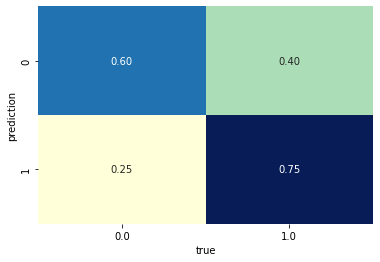

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
classification accuracy 0.7294117647058823
F1 score 0.5862433862433862


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


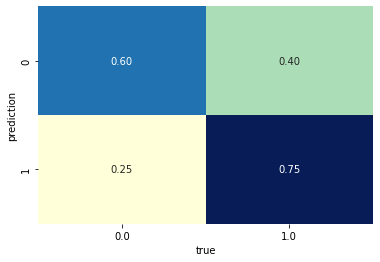

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
classification accuracy 0.6705882352941176
F1 score 0.582748948106592


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


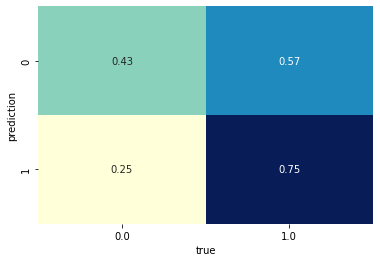

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
classification accuracy 0.5058823529411764
F1 score 0.49


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


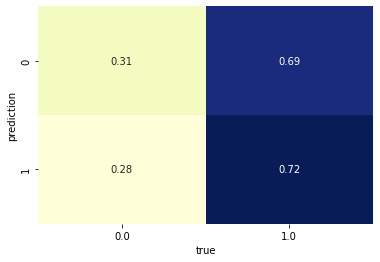

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
classification accuracy 0.4588235294117647
F1 score 0.4587486157253599


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


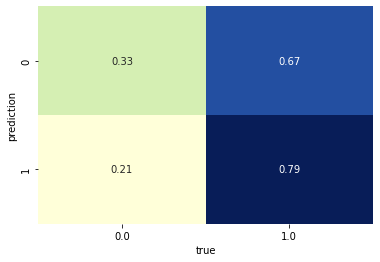

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
classification accuracy 0.7294117647058823
F1 score 0.6173419455862204


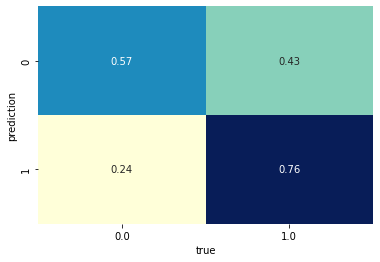

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
classification accuracy 0.7058823529411765
F1 score 0.41379310344827586


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


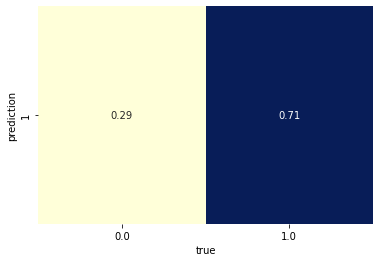

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
classification accuracy 0.6941176470588235
F1 score 0.4097222222222222


/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


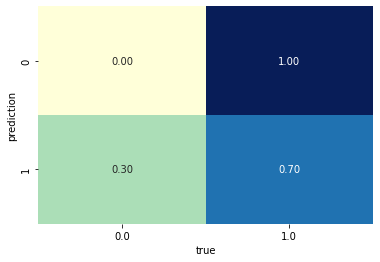

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |

/gpfs/home/sc9295/.local/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["5"]
  warnings.warn(w)


███████████████████████████████████████████████████████| (done) 100%
classification accuracy 0.7294117647058823
F1 score 0.5462984451148758


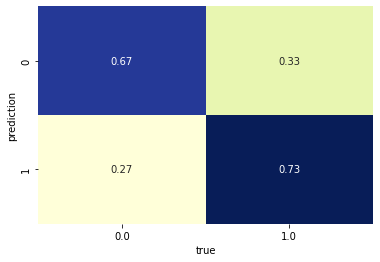

In [108]:
# regression
evaluation_metrics = 'accuracy'
model_path_dir = '/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/model_saved/'
model_id_list = list(df_dev.loc[df_dev.groupby('model_family')[f'{evaluation_metrics}_mean'].idxmax()].reset_index(drop=True).sort_values(by=f'{evaluation_metrics}_mean',ascending=False)['model_id'].values)

for i, model_id in enumerate(model_id_list):
    model_path = os.path.join(model_path_dir,model_id)
    uploaded_model = h2o.upload_model(model_path)
    m = h2o.get_model(model_id)
#     print(m)
    regression_pred = m.predict(test_h2o).as_data_frame()['predict']
    regression_true = test_h2o.as_data_frame()[dataset.target]
    m.model_performance(test_h2o)

    X = test.drop(columns=dataset.target)
    true = test[dataset.target]
    pred = m.predict(test_h2o).as_data_frame()['predict']

    baseline = test['DAS28_CRP_0M']

    baseline, true, pred = np.array(baseline), np.array(true), np.squeeze(np.array(pred))

    print("classification accuracy", Classification_Accuracy(true,pred))
    print("F1 score", F1_Score(true,pred))

    contingency_matrix = pd.crosstab(true, pred, rownames=['true'], colnames=[
                                                 'prediction'], normalize='columns')
    plt.figure(i)
    sns.heatmap(contingency_matrix.T, annot=True,
                fmt='.2f', cmap="YlGnBu", cbar=False)
    plt.show()


# 3 Class 

In [3]:
df = pd.read_csv('/gpfs/home/sc9295/Projects/ML_RA_EHR/leaderboard/SC_3_Class_classification_Aug4_final_output.csv')
df

,dataset,challenge,model_id,accuracy_mean,auc_mean,err_mean,err_count_mean,logloss_mean,max_per_class_error_mean,mean_per_class_accuracy_mean,...,err_std,err_count_std,logloss_std,max_per_class_error_std,mean_per_class_accuracy_std,mean_per_class_error_std,mse_std,pr_auc_std,r2_std,rmse_std
0,val,classification,XGBoost_lr_search_selection_AutoML_1_20220804_...,0.493333,NaN,0.506667,14.8,1.117331,0.641850,0.490399,...,0.101999,2.993326,0.093444,0.101413,0.106920,0.106920,0.037961,NaN,0.148965,0.029845
1,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_4,0.466207,NaN,0.533793,15.6,1.284930,0.669231,0.458704,...,0.089313,2.690725,0.166497,0.063925,0.091828,0.091828,0.049273,NaN,0.163423,0.038199
2,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_77,0.455287,NaN,0.544713,15.9,1.205735,0.727668,0.444451,...,0.092098,2.662705,0.134506,0.128667,0.107839,0.107839,0.047732,NaN,0.146333,0.037997
3,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_5,0.458851,NaN,0.541149,15.8,1.198201,0.744350,0.437040,...,0.059355,1.720465,0.097984,0.126907,0.076290,0.076290,0.033008,NaN,0.154472,0.025372
4,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_80,0.455172,NaN,0.544828,15.9,1.142135,0.757848,0.427622,...,0.064483,1.813836,0.076079,0.141538,0.089539,0.089539,0.029611,NaN,0.157187,0.022906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,val,classification,StackedEnsemble_BestOfFamily_1_AutoML_1_202208...,0.364437,NaN,0.635563,18.6,1.095878,0.954603,0.326274,...,0.063249,4.079216,0.056621,0.072212,0.037670,0.037670,0.021488,NaN,0.062115,0.016181
141,val,classification,DeepLearning_grid_3_AutoML_1_20220804_154218_m...,0.366552,NaN,0.633448,18.5,1.086362,0.985714,0.338237,...,0.080533,2.376973,0.044760,0.042857,0.047889,0.047889,0.017698,NaN,0.093615,0.013557
142,val,classification,StackedEnsemble_AllModels_4_AutoML_1_20220804_...,0.328034,NaN,0.671966,19.7,1.209710,0.847727,0.316987,...,0.057744,4.712749,0.142141,0.092350,0.045092,0.045092,0.036354,NaN,0.090372,0.026954
143,val,classification,DeepLearning_grid_1_AutoML_1_20220804_154218_m...,0.315057,NaN,0.684943,20.0,2.099808,0.895436,0.278975,...,0.051794,1.549193,0.472657,0.110938,0.054151,0.054151,0.041511,NaN,0.168007,0.028644


In [7]:
df_dev = df
df_dev.loc[:,'model_family'] = df_dev.apply(lambda row:add_model_family(row),axis=1)
df_dev

,dataset,challenge,model_id,accuracy_mean,auc_mean,err_mean,err_count_mean,logloss_mean,max_per_class_error_mean,mean_per_class_accuracy_mean,...,err_count_std,logloss_std,max_per_class_error_std,mean_per_class_accuracy_std,mean_per_class_error_std,mse_std,pr_auc_std,r2_std,rmse_std,model_family
0,val,classification,XGBoost_lr_search_selection_AutoML_1_20220804_...,0.493333,NaN,0.506667,14.8,1.117331,0.641850,0.490399,...,2.993326,0.093444,0.101413,0.106920,0.106920,0.037961,NaN,0.148965,0.029845,XGBoost
1,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_4,0.466207,NaN,0.533793,15.6,1.284930,0.669231,0.458704,...,2.690725,0.166497,0.063925,0.091828,0.091828,0.049273,NaN,0.163423,0.038199,XGBoost
2,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_77,0.455287,NaN,0.544713,15.9,1.205735,0.727668,0.444451,...,2.662705,0.134506,0.128667,0.107839,0.107839,0.047732,NaN,0.146333,0.037997,XGBoost
3,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_5,0.458851,NaN,0.541149,15.8,1.198201,0.744350,0.437040,...,1.720465,0.097984,0.126907,0.076290,0.076290,0.033008,NaN,0.154472,0.025372,XGBoost
4,val,classification,XGBoost_grid_1_AutoML_1_20220804_154218_model_80,0.455172,NaN,0.544828,15.9,1.142135,0.757848,0.427622,...,1.813836,0.076079,0.141538,0.089539,0.089539,0.029611,NaN,0.157187,0.022906,XGBoost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,val,classification,StackedEnsemble_BestOfFamily_1_AutoML_1_202208...,0.364437,NaN,0.635563,18.6,1.095878,0.954603,0.326274,...,4.079216,0.056621,0.072212,0.037670,0.037670,0.021488,NaN,0.062115,0.016181,StackedEnsemble_BestOfFamily
141,val,classification,DeepLearning_grid_3_AutoML_1_20220804_154218_m...,0.366552,NaN,0.633448,18.5,1.086362,0.985714,0.338237,...,2.376973,0.044760,0.042857,0.047889,0.047889,0.017698,NaN,0.093615,0.013557,DeepLearning
142,val,classification,StackedEnsemble_AllModels_4_AutoML_1_20220804_...,0.328034,NaN,0.671966,19.7,1.209710,0.847727,0.316987,...,4.712749,0.142141,0.092350,0.045092,0.045092,0.036354,NaN,0.090372,0.026954,StackedEnsemble_AllModels
143,val,classification,DeepLearning_grid_1_AutoML_1_20220804_154218_m...,0.315057,NaN,0.684943,20.0,2.099808,0.895436,0.278975,...,1.549193,0.472657,0.110938,0.054151,0.054151,0.041511,NaN,0.168007,0.028644,DeepLearning


In [8]:
def addlabels(ax,x,y):
    for i in range(len(x)):
        ax.text(i, (y[i])//2, y[i], ha = 'center', color='white',fontsize=12)

In [9]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
#     x = list(df['model_id'])
#     y = df[f'{evaluation_metrics}_mean']
    y_1 = [round(a,2) for a in y]
#     y_error = df[f'{evaluation_metrics}_std']
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 0 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'accuracy':
        ax1.set_ylim(0,100)
        bars = ax1.bar(x,y_perc,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
    addlabels(ax1,x,y_perc)
#     ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Accuracy(%)', fontsize=20)
    
    ax1.errorbar(x, y_perc, yerr=y_error_perc,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
    

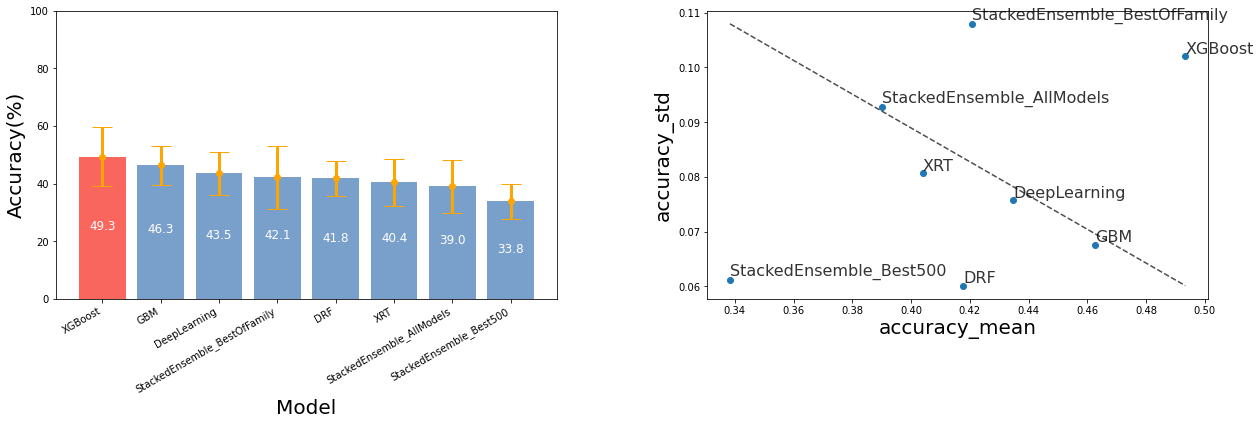

In [10]:
# top_k, top_k_error, test = filter_data(rank_metrix='MSE',challenge='regression',topk=5)
error_bar_plot(df_dev, 'accuracy')

In [42]:
def error_bar_plot(df, evaluation_metrics):
    selected_models = df.sort_values(by=f'{evaluation_metrics}_mean',ascending=False).groupby('model_family').first()
    selected_models = selected_models.sort_values(by=f'{evaluation_metrics}_mean', ascending=False)
    y = selected_models[f'{evaluation_metrics}_mean']
    x = y.index
    y_error = selected_models[f'{evaluation_metrics}_std']
    
    y_1 = [round(a,2) for a in y]
    y_error_perc = [a*100 for a in y_error]
    y_perc = [round(a*100,1) for a in y]
    colors = ["#F9665E" if i == 1 else "#799FCB" for i in range(len(x))]

    fig, (ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    if evaluation_metrics == 'mse':
        ax1.set_ylim(0,max(y+y_error)+0.5)
        bars = ax1.bar(x,y_1,color=colors)
    elif evaluation_metrics == 'auc':
        ax1.set_ylim(0,1)
        bars = ax1.bar(x,y_1,color=colors)
    else:
        bars = ax1.bar(x,y,color=colors)
        
#     addlabels(ax1,x,y_1)
    ax1.bar_label(bars,label_type='center', color='white', fontsize=12)
    ax1.set_xlabel('Model', fontsize=20)
    ax1.set_ylabel('Area under ROC', fontsize=20)
    
    ax1.errorbar(x, y, yerr=y_error,
              fmt='o', color='orange', ecolor='orange',
              elinewidth = 3, capsize=10)
    
    ax2.scatter(y,y_error)
    for i in range(len(x)):
        alignment = 'left' if y[i] < 0.800 else 'right'
        ax2.text(x=y[i], y=y_error[i], s=x[i], 
                 horizontalalignment=alignment, verticalalignment='bottom',
                 fontdict=dict(color='black', alpha=0.8, size=16))
                    
    ax2.plot([min(y), max(y)], [max(y_error), min(y_error)], ls="--", c=".3")
#     ax2.arrow(min(y), max(y_error), -0.01,0.02)
    ax2.set_xlabel(f'{evaluation_metrics}_mean', fontsize=20)
    ax2.set_ylabel(f'{evaluation_metrics}_std', fontsize=20)
    
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.2)
    